<a href="https://colab.research.google.com/github/Humzafazal72/Brain-Tumor-Detection/blob/master/Brain_Tumor_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brain-tumor-image-dataset-semantic-segmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4327785%2F7436152%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240831%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240831T144201Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6b007eaca2aac5243351ee863338bb572dec93aec5a27ec6b8677d359a8566b9493233188dc2909449bc3dff060498efacc13fdf7af2676116c7bd161f33ecb5bb71478c76d1081fe549cd4ccb1434487c268f4421d84f0fea35222d8f180bb59e451fe51ad2a19ae1a1d908781d92590d08a315a6eaf33523f7e89e06afb814f408598b9d9b8df6360c57d403ffbf765c8ca42ff27d2156c9bc7b9c8d097384f2396bac60062118a00ff5ba18796da8f814082434cb46698d8712fd53cb820c9c56ace0f2e63ab9013c8f670d8cfb582fb05dc05c2237b164bac9c29c212e8095425279e507955f49c08da297a3d1b9e2426a9c4068ec4f53f4cf493ec8d14c,modelss:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5622656%2F9288145%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240831%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240831T144201Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D03d26de6b810da6d269f15c8b6bbd95df53da00a5cd187b10da32bdcb75a40b9b5a2d05077792b7bb35889abd3686b67ee2d2faceaffd47cb11f3a765701be1616a8013cbb0c7a1b653d67eeedfda9e58e22eb703cb36993d3a22cb7b963b4edeb57cd3a9c75a1195b72f4787259035ce6f903736f98375ba1641d684083aba1412bef52fd07b7e3d041f9ec6e661c15ce504179576843478d4b3474f66e9a54fd9094de66066e7acae6fa6c3d23b54282012c6d49a1ff66914943ff4415e8382286f54fc9eda8b26ff35153b93a7ff869ec2688aa30d6deac72c38c2f51b259a297a484da0dc7b756910e680d122279add59495e1c63a76b3357ccb09a74f9d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 87755658 bytes downloaded
Downloaded and uncompressed: brain-tumor-image-dataset-semantic-segmentation
[==================================================] 296907233 bytes downloaded
Downloaded and uncompressed: modelss
Data source import complete.


In [2]:
import json
# load json file for training data
with open('/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train/_annotations.coco.json','r') as file:
    train = json.load(file)
# load json file for validation data
with open('/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/_annotations.coco.json','r') as file:
    valid = json.load(file)
# load json file for test data
with open('/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test/_annotations.coco.json','r') as file:
    test = json.load(file)

## **Visualizating Dataset**


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

train_dir = "/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train"

def plot_image_mask(img_name, segmentation, bbox):
    fig, ax = plt.subplots(1, 2)
    img_path = os.path.join(train_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    scale_x = 256 / 640
    scale_y = 256 / 640
    # Scale bounding box
    scaled_bbox = [int(bbox[0] * scale_x), int(bbox[1] * scale_y), int(bbox[2] * scale_x), int(bbox[3] * scale_y)]

    # Draw bounding box
    img_copy = img.copy()
    cv2.rectangle(img_copy, (scaled_bbox[0], scaled_bbox[1]), (scaled_bbox[0] + scaled_bbox[2], scaled_bbox[1] + scaled_bbox[3]), thickness=2, color=(0, 255, 0))

    # Scale and draw segmentation mask
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    polygon = np.array(segmentation[0]).reshape((-1, 2))
    scaled_polygon = polygon * [scale_x, scale_y]
    cv2.fillPoly(mask, [scaled_polygon.astype(int)], 255)

    ax[0].imshow(img_copy)
    ax[1].imshow(mask, cmap='gray')
    plt.show()


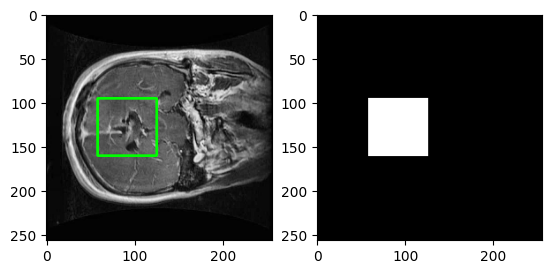

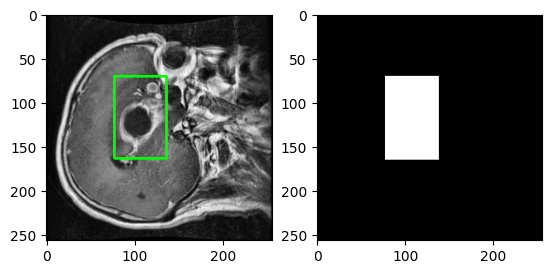

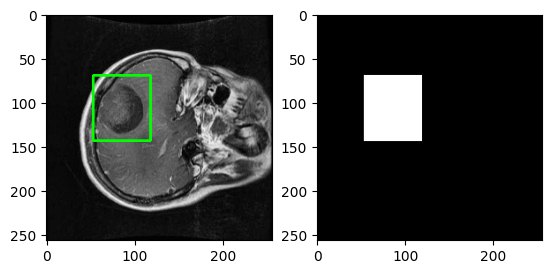

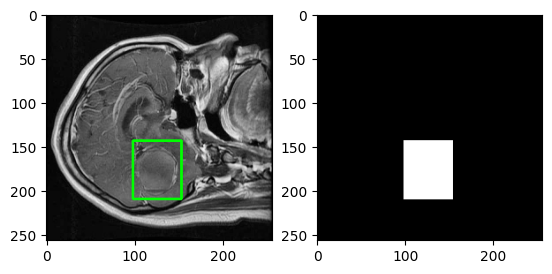

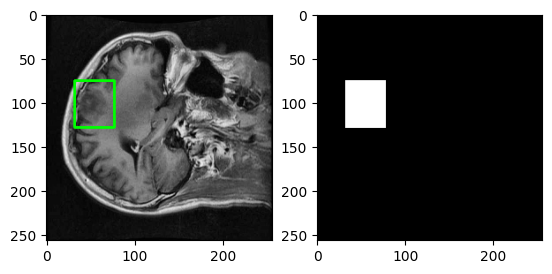

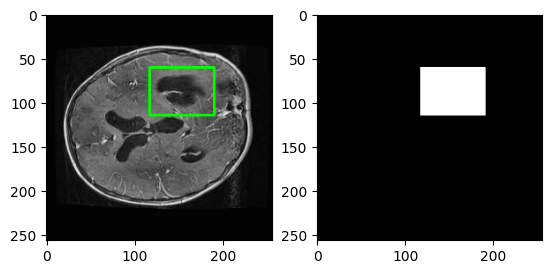

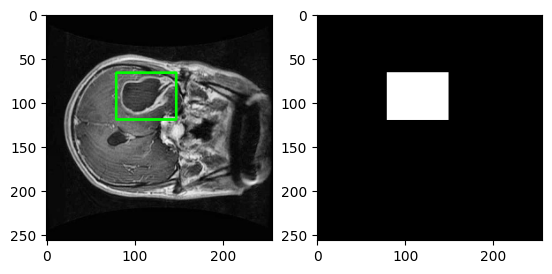

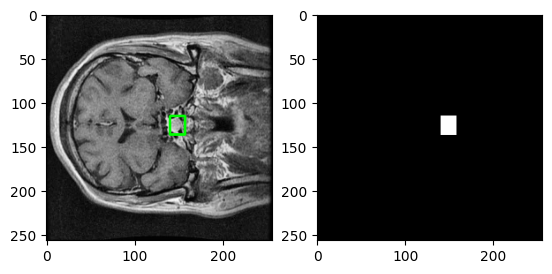

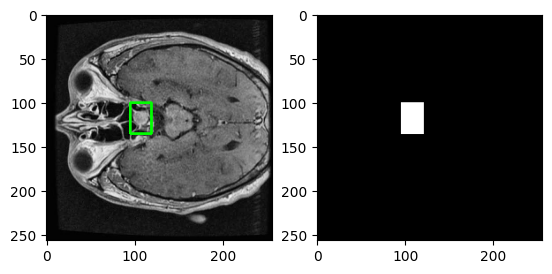

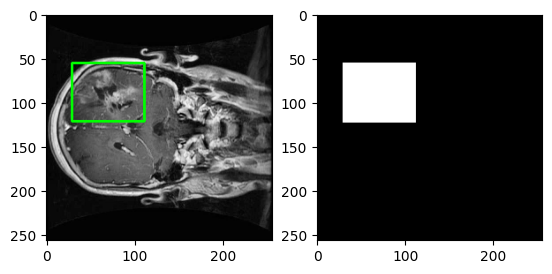

In [4]:
#visualizing the first 10 images
for i in range(10):
    img_name,seg = train['images'][i]['file_name'],[train['annotations'][i]['segmentation']]
    bbox = train['annotations'][i]['bbox']
    plot_image_mask(img_name,seg,bbox)

# **Pytorch Dataset Creation**

In [5]:
import torch
from torch.utils.data import Dataset,DataLoader

In [6]:
class TumorDataset(Dataset):
    def __init__(self,img_dir,data):
        self.img_dir = img_dir
        self.img_name_ls = [img['file_name'] for img in data['images']]
        self.img_seg_ls = [ann['segmentation'][0] for ann in data['annotations']]

    def __len__(self):
        return len(self.img_name_ls)

    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_name_ls[idx])
        img = cv2.imread(img_path)
        img = cv2.resize(img, (256, 256))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        scale_x = 256 / 640
        scale_y = 256 / 640

        mask = np.zeros((256,256),np.uint8)
        poly = np.array(self.img_seg_ls[idx]).reshape(-1,2)
        scaled_poly = poly * [scale_x, scale_y]
        cv2.fillPoly(mask,[scaled_poly.astype(int)],255)

        img = torch.tensor(img.transpose(2, 0, 1) / 255.0, dtype=torch.float32)
        mask = torch.tensor(mask / 255.0, dtype=torch.float32)

        return img,mask

In [7]:
train_data = TumorDataset(img_dir='/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train',
                         data = train)
val_data = TumorDataset(img_dir='/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid',
                         data = valid)
test_data = TumorDataset(img_dir='/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test',
                         data = test)

In [8]:
train_loader = DataLoader(
                train_data,
                batch_size = 16,
                shuffle = True,
                num_workers=4)
val_loader = DataLoader(
                val_data,
                batch_size = 1,
                shuffle = False,)
test_loader = DataLoader(
                test_data,
                batch_size = 1,
                shuffle = False)

# **Creating Custom Model(UNET)**

In [9]:
import torch.nn as nn

In [10]:
def downsample(in_, out_, drop=True):
    layers = [
        nn.Conv2d(in_, out_, kernel_size=(3, 3), padding='same', stride=1),
        nn.BatchNorm2d(out_),
        nn.ReLU(0.2)
    ]
    if drop:
        layers.append(nn.Dropout(0.1))
    return nn.Sequential(*layers)

In [11]:
def upsample(in_,out_,transpose=False):
    if transpose!=True:
        return nn.Sequential(
        nn.Conv2d(in_,out_,kernel_size=3,padding='same',stride=1),
        nn.ReLU(),
        nn.Conv2d(out_,out_,kernel_size=3,padding='same',stride=1),
        nn.ReLU())

    return nn.Sequential(
        nn.ConvTranspose2d(in_,out_,kernel_size=2,stride=2),
        nn.ReLU()
    )

In [12]:
class UNET(nn.Module):
    def __init__(self,in_=3,out_=32):
        super(UNET, self).__init__()
        self.d1 = downsample(in_,out_) #256x256,32
        self.d2 = downsample(out_,out_) # 256x256x32
        self.mp1 = nn.MaxPool2d((2,2),stride=2) #(256-2/2)+1 = 128x128x32

        self.d3 = downsample(out_,out_*2) #128x128x64
        self.d4 = downsample(out_*2,out_*2) #128x128x64
        self.mp2 = nn.MaxPool2d((2,2),stride=2) # (128-2/2)+1=64x64x64

        self.d5 = downsample(out_*2,out_*2*2) #64x64x128
        self.d6 = downsample(out_*2*2,out_*2*2) #64x64x128
        self.mp3 = nn.MaxPool2d((2,2),stride=2) #(128-2/2)+1=32x32x128

        self.d7 = downsample(out_*2*2,out_*2*2*2) #32x32x256
        self.d8 = downsample(out_*2*2*2,out_*2*2*2,drop=True) #32x32x256
        self.mp4 = nn.MaxPool2d((2,2),stride=2) #(32-2/2)+1=16x16x256

        self.d9 = downsample(out_*2*2*2,out_*2*2*2*2,drop=True) #16x16x512
        self.mp5 = nn.MaxPool2d((2,2),stride=2) #(16-2/2)+1=8x8x512

        self.bn = nn.Conv2d(out_*2*2*2*2,out_*2*2*2*2,(3,3),padding='same',stride=1) #8x8x512

        self.up0 = nn.Conv2d(out_*2*2*2*2,out_*2*2*2*2,(3,3),padding='same',stride=1) #8x8x512

        self.up1_1 = upsample(out_*2*2*2*2,out_*2*2*2*2,transpose=True) #16x16x512
        self.up1_2 = upsample(out_*2*2*2*2*2,out_*2*2*2*2) #16x16x512

        self.up2_1 = upsample(out_*2*2*2*2,out_*2*2*2,transpose=True) #32x32x256
        self.up2_2 = upsample(out_*2*2*2*2,out_*2*2*2) #32x32x256

        self.up3_1 = upsample(out_*2*2*2,out_*2*2,transpose=True) #64x64x128
        self.up3_2 = upsample(out_*2*2*2,out_*2*2) #64x64x128

        self.up4_1 = upsample(out_*2*2,out_*2,transpose=True) #128x128x64
        self.up4_2 = upsample(out_*2*2,out_*2) #128x128x64

        self.up5_1 = upsample(out_*2,out_,transpose=True) #256x256x32
        self.up5_2 = upsample(out_*2,out_) #256x256x32

        self.final = nn.Conv2d(out_,1,kernel_size=1,stride=1,padding='same')

    def forward(self,x):
        d1 = self.d1(x)
        d2 = self.d2(d1)
        mp1 = self.mp1(d2)

        d3 = self.d3(mp1)
        d4 = self.d4(d3)
        mp2 = self.mp2(d4)

        d5 = self.d5(mp2)
        d6 = self.d6(d5)
        mp3 = self.mp3(d6)

        d7 = self.d7(mp3)
        d8 = self.d8(d7)
        mp4 = self.mp4(d8)

        d9 = self.d9(mp4)
        mp5 = self.mp5(d9)

        bn = self.bn(mp5)

        up0 = self.up0(bn)

        up1_1 = self.up1_1(up0)
        up1_2 = self.up1_2(torch.cat([up1_1,d9],1))

        up2_1 = self.up2_1(up1_2)
        up2_2 = self.up2_2(torch.cat([up2_1,d8],1))

        up3_1 = self.up3_1(up2_2)
        up3_2 = self.up3_2(torch.cat([up3_1,d6],1))

        up4_1 = self.up4_1(up3_2)
        up4_2 = self.up4_2(torch.cat([up4_1,d4],1))

        up5_1 = self.up5_1(up4_2)
        up5_2 = self.up5_2(torch.cat([up5_1,d2],1))

        final = self.final(up5_2)

        return nn.Sigmoid()(final)

In [13]:
# testing the model architecture
test = torch.randn(size=(1,3,256,256))
unet = UNET()
out = unet(test)
out.size()

torch.Size([1, 1, 256, 256])

## Training

In [14]:
from tqdm import tqdm

In [15]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 30

In [16]:
unet = UNET().to(DEVICE)
optimizer = torch.optim.Adam(unet.parameters())
criterion = nn.BCELoss()

In [ ]:
for epoch in range(EPOCHS):
    running_loss = 0.0
    unet.train()
    for mri, mask in tqdm(train_loader):
        mri, mask = mri.to(DEVICE), mask.to(DEVICE)

        optimizer.zero_grad()
        pred = unet(mri)
        loss = criterion(pred, mask.unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Loss: {running_loss/len(train_loader):.4f}")

100%|██████████| 94/94 [00:17<00:00,  5.26it/s]


Loss: 0.1731


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.1210


100%|██████████| 94/94 [00:16<00:00,  5.62it/s]


Loss: 0.1162


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.1078


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.1041


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.1017


100%|██████████| 94/94 [00:16<00:00,  5.60it/s]


Loss: 0.0978


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.1000


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.1008


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.0966


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.0940


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.0941


100%|██████████| 94/94 [00:16<00:00,  5.60it/s]


Loss: 0.0913


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.0908


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.0908


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.0882


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.0880


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.0865


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.0858


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.0872


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.0866


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.0835


100%|██████████| 94/94 [00:16<00:00,  5.60it/s]


Loss: 0.0848


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.0821


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.0852


100%|██████████| 94/94 [00:16<00:00,  5.62it/s]


Loss: 0.0846


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.0806


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.0792


100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Loss: 0.0785


100%|██████████| 94/94 [00:16<00:00,  5.60it/s]

Loss: 0.0776


In [ ]:
torch.save(unet.state_dict(), 'unet_model_custom.pth')

# **Creating UNET models using segmentation-models-pytroch**

In [17]:
!pip install huggingface_hub==0.15.1
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.23.5
    Uninstalling huggingface-hub-0.23.5:
      Successfully uninstalled huggingface-hub-0.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tokenizers 0.19.1 requires huggingface-hub<1.0,>=0.16.4, but you have huggingface-hub 0.15.1 which is incompatible.
transformers 4.42.4 requires huggingface-hub<1.0,>=0.23.2, but you have huggingface-hub 0.15.1 which is incompatible.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 4.2 MB/s eta 0:00:0

In [18]:
import segmentation_models_pytorch as smp

## Using Resnet50 as encoder

In [19]:
model_resnet50 = smp.Unet(
encoder_name = 'resnet50',
encoder_weights = 'imagenet',
in_channels=3,
classes=1,
activation = 'sigmoid'
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s]


In [20]:
!export CUDA_LAUNCH_BLOCKING=1
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet50 = model_resnet50.to(DEVICE)
optimizer = torch.optim.Adam(model_resnet50.parameters())
criterion = nn.BCELoss()
EPOCHS = 10

In [ ]:
for epoch in range(EPOCHS):
    running_loss = 0.0
    model_resnet50.train()
    for mri, mask in tqdm(train_loader):
        mri, mask = mri.to(DEVICE), mask.to(DEVICE)

        optimizer.zero_grad()
        pred = model_resnet50(mri)
        loss = criterion(pred, mask.unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Loss: {running_loss/len(train_loader):.4f}")

100%|██████████| 94/94 [00:30<00:00,  3.11it/s]


Loss: 0.1869


100%|██████████| 94/94 [00:29<00:00,  3.19it/s]


Loss: 0.0972


100%|██████████| 94/94 [00:30<00:00,  3.12it/s]


Loss: 0.0872


100%|██████████| 94/94 [00:30<00:00,  3.06it/s]


Loss: 0.0802


100%|██████████| 94/94 [00:30<00:00,  3.08it/s]


Loss: 0.0761


100%|██████████| 94/94 [00:30<00:00,  3.09it/s]


Loss: 0.0733


100%|██████████| 94/94 [00:30<00:00,  3.08it/s]


Loss: 0.0670


100%|██████████| 94/94 [00:30<00:00,  3.08it/s]


Loss: 0.0638


100%|██████████| 94/94 [00:34<00:00,  2.69it/s]


Loss: 0.0590


100%|██████████| 94/94 [00:30<00:00,  3.07it/s]

Loss: 0.0553


In [ ]:
torch.save(model_resnet50.state_dict(), 'model_resnet50.pth')

## Using VGG19bn as encoder

In [21]:
model_vgg19 =smp.Unet(
encoder_name = 'vgg19_bn',
encoder_weights = 'imagenet',
in_channels=3,
classes=1,
activation = 'sigmoid'
)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:01<00:00, 400MB/s]


In [22]:
!export CUDA_LAUNCH_BLOCKING=1
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vgg19 = model_vgg19.to(DEVICE)
optimizer = torch.optim.Adam(model_vgg19.parameters())
criterion = nn.BCELoss()
EPOCHS = 10

In [ ]:
for epoch in range(EPOCHS):
    running_loss = 0.0
    model_vgg19.train()
    for mri, mask in tqdm(train_loader):
        mri, mask = mri.to(DEVICE), mask.to(DEVICE)

        optimizer.zero_grad()
        pred = model_vgg19(mri)
        loss = criterion(pred, mask.unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Loss: {running_loss/len(train_loader):.4f}")

In [ ]:
torch.save(model_vgg19.state_dict(), 'model_vgg19.pth')

# **Evaluation**

In [50]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_custom = torch.load('/kaggle/input/modelss/unet_model_custom.pth',map_location=DEVICE)
checkpoint_resnet = torch.load('/kaggle/input/modelss/model_resnet50.pth',map_location=DEVICE)
checkpoint_vgg = torch.load('/kaggle/input/modelss/model_vgg19.pth',map_location=DEVICE)

unet.load_state_dict(checkpoint_custom)
model_resnet50.load_state_dict(checkpoint_resnet)
model_vgg19.load_state_dict(checkpoint_vgg)

models = [unet,model_resnet50,model_vgg19]

<ipython-input-50-d8fcb3586632>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_custom = torch.load('/kaggle/input/modelss/unet_model_custom.pth',map_location=DE

## BCELoss on Test and Validation Set


In [51]:
def evaluation(model,dataloader):
    model.eval()
    with torch.no_grad():
        loss = 0.0
        for mri, mask in dataloader:
            mri, mask = mri.to(DEVICE), mask.to(DEVICE)
            pred = model(mri)
            loss += criterion(pred, mask.unsqueeze(1)).item()
    return loss/len(dataloader)

In [54]:
models_loss = {}
for model in tqdm(models):
  evaluation_val = evaluation(model,val_loader)
  evaluation_test = evaluation(model,test_loader)
  models_loss[model.__class__.__name__] = evaluation_val,evaluation_test
  break


  0%|          | 0/3 [00:29<?, ?it/s]


In [58]:
vgg_loss_test = evaluation(model_vgg19,test_loader)
vgg_loss_val = evaluation(model_vgg19,val_loader)

resnet_loss_test = evaluation(model_resnet50,test_loader)
resnet_loss_val = evaluation(model_resnet50,val_loader)

custom_net_loss_test = evaluation(unet,test_loader)
custom_net_loss_val = evaluation(unet,val_loader)

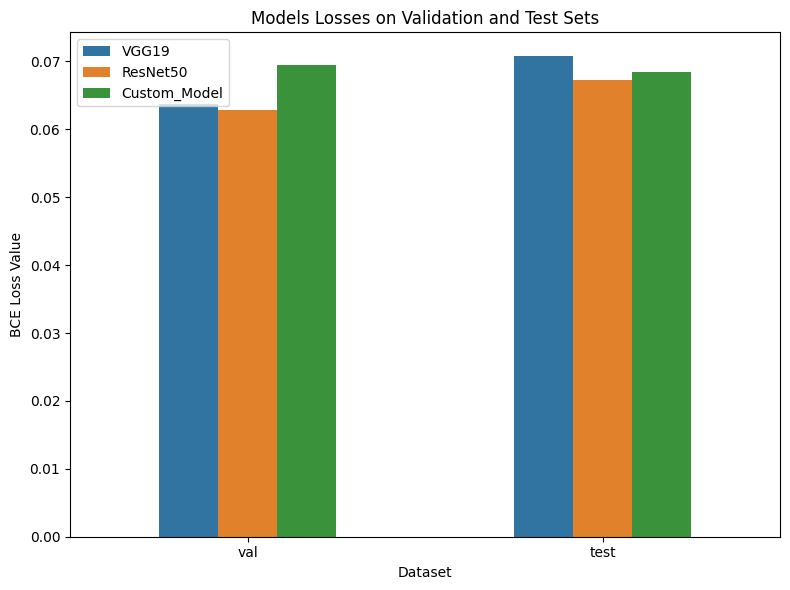

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = {
    'Model': ['VGG19', 'VGG19', 'ResNet50', 'ResNet50', 'Custom_Model', 'Custom_Model'],
    'Dataset': ['val', 'test', 'val', 'test', 'val', 'test'],
    'BCE Loss Value': [vgg_loss_val, vgg_loss_test, resnet_loss_val, resnet_loss_test, custom_net_loss_val, custom_net_loss_test]
}

df = pd.DataFrame(data)
plt.figure(figsize=(8, 6))
sns.barplot(x='Dataset', y='BCE Loss Value', hue='Model', data=df, width=0.5)

plt.title('Models Losses on Validation and Test Sets')
plt.ylabel('BCE Loss Value')
plt.xlabel('Dataset')

plt.legend(loc='upper left')
plt.tight_layout()

plt.show()


## ***Iou* Calculation on Test Set**

In [128]:
import torch.nn.functional as F

def mse(mask1, mask2):
    return F.mse_loss(mask1, mask2).item()

# vgg19_bn
vgg19_MSEs = []
model_vgg19.eval()

resnet_MSEs = []
model_resnet50.eval()

unet_MSEs = []
unet.eval()

with torch.no_grad():
    for mri, mask in tqdm(test_loader):
        mri, mask = mri.to(DEVICE), mask.to(DEVICE)
        mask = mask.squeeze()

        pred_vgg = model_vgg19(mri)
        vgg19_MSEs.append(mse(pred_vgg.squeeze().squeeze(), mask))

        pred_resnet = model_resnet50(mri)
        resnet_MSEs.append(mse(pred_resnet.squeeze().squeeze(), mask))

        pred_unet = unet(mri)
        unet_MSEs.append(mse(pred_unet.squeeze().squeeze(), mask))


100%|██████████| 215/215 [00:35<00:00,  5.99it/s]


<ipython-input-145-28f398acc8db>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vgg19_MSEs, hist=False, label='VGG19 MSE')
<ipython-input-145-28f398acc8db>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(resnet_MSEs, hist=False, label='ResNet50 MSE')
<ipython-input-145-28f39

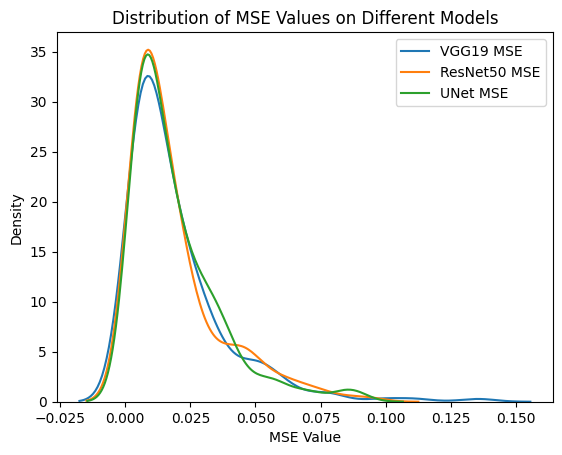

In [145]:
sns.distplot(vgg19_MSEs, hist=False, label='VGG19 MSE')
sns.distplot(resnet_MSEs, hist=False, label='ResNet50 MSE')
sns.distplot(unet_MSEs, hist=False, label='UNet MSE')

plt.xlabel('MSE Value')
plt.ylabel('Density')
plt.title('Distribution of MSE Values on Different Models')
plt.legend()
plt.show()

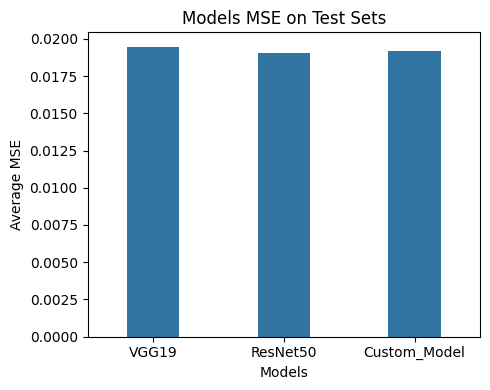

In [143]:
data = {
    'Model': ['VGG19', 'ResNet50', 'Custom_Model'],
    'mse': [sum(vgg19_MSEs)/len(vgg19_MSEs), sum(resnet_MSEs)/len(vgg19_MSEs), sum(unet_MSEs)/len(vgg19_MSEs)]
}

df = pd.DataFrame(data)

plt.figure(figsize=(5, 4))
sns.barplot(x='Model', y='mse', data=df, width=0.4)

plt.title('Models MSE on Test Sets')
plt.ylabel('Average MSE')
plt.xlabel('Models')

plt.tight_layout()

plt.show()


# **Plotting results**

In [102]:
import random

model_vgg19.eval()
model_resnet50.eval()
unet.eval()

to_plot_vgg= []
to_plot_resnet= []
to_plot_custom= []
to_plot_mask= []
to_plot_img = []

with torch.no_grad():
    for img,mask in test_loader:
        if len(to_plot_vgg)==10:
            break
        if random.choice(np.arange(0,3)) == 2:
            to_plot_vgg.append(model_vgg19(img.to(DEVICE)).detach().to('cpu').numpy())
            to_plot_resnet.append(model_resnet50(img.to(DEVICE)).detach().to('cpu').numpy())
            to_plot_custom.append(unet(img.to(DEVICE)).detach().to('cpu').numpy())
            to_plot_mask.append(mask.detach().numpy())
            to_plot_img.append(img.detach().numpy())

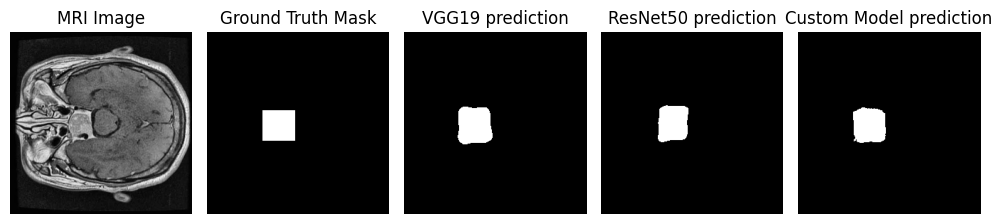

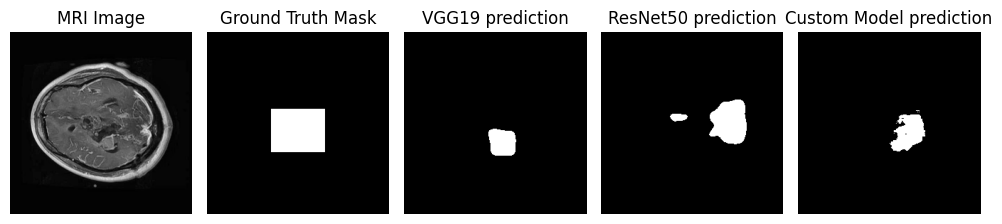

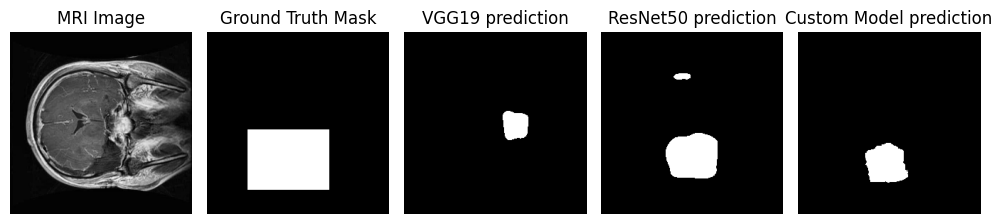

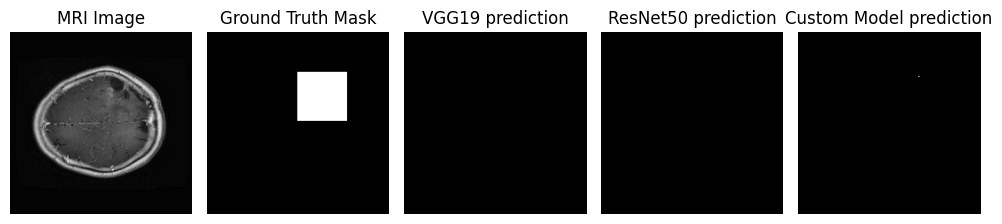

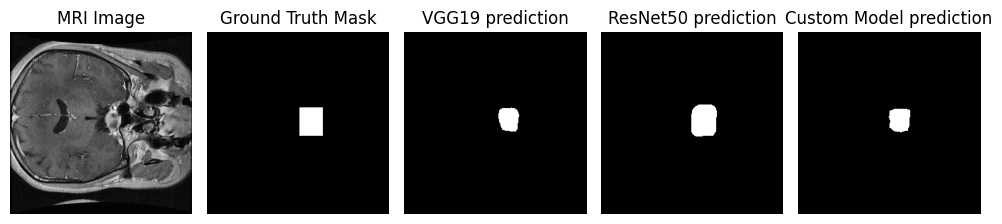

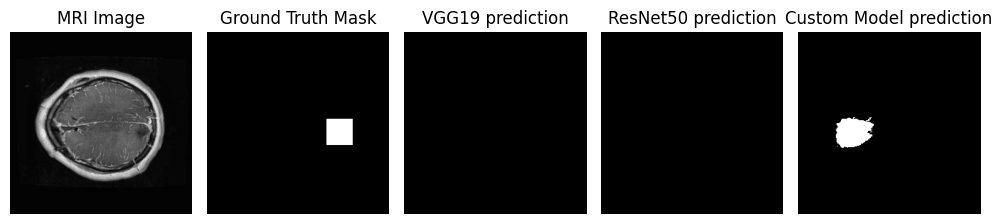

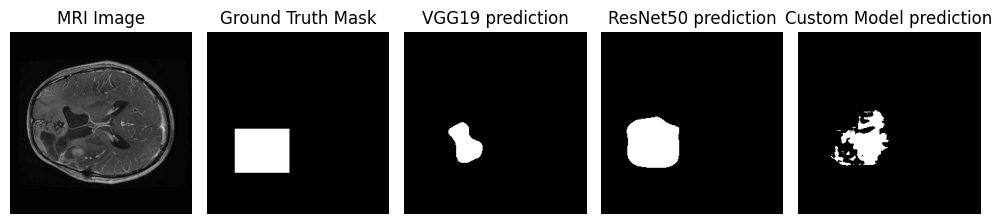

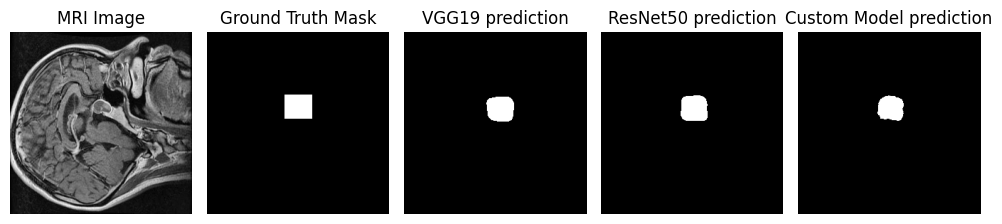

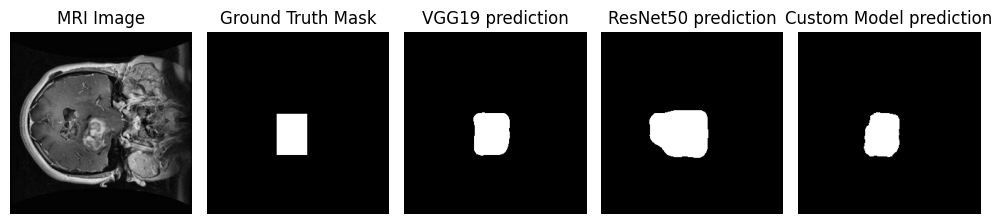

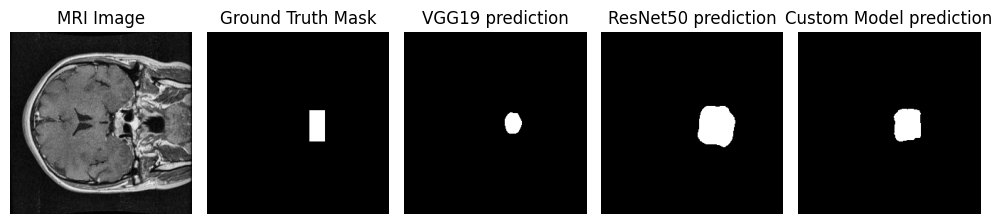

In [108]:
def process_output(img):
  img = img.reshape(256,256)
  img = np.where(img >= 0.5, 1, 0)
  return img

for i,img in enumerate(to_plot_img):
  fig,ax = plt.subplots(1,5,figsize=(10,10))

  ax[0].imshow(img.reshape(3,256,256).transpose(1, 2, 0))
  ax[1].imshow(to_plot_mask[i].reshape(256,256),cmap='gray')

  vgg,resnet,custom = process_output(to_plot_vgg[i]),process_output(to_plot_resnet[i]),process_output(to_plot_custom[i])
  ax[2].imshow(vgg,cmap='gray')
  ax[3].imshow(resnet,cmap='gray')
  ax[4].imshow(custom,cmap='gray')

  ax[0].set_title('MRI Image')
  ax[1].set_title('Ground Truth Mask')
  ax[2].set_title('VGG19 prediction')
  ax[3].set_title('ResNet50 prediction')
  ax[4].set_title('Custom Model prediction')

  ax[0].axis('off')
  ax[1].axis('off')
  ax[2].axis('off')
  ax[3].axis('off')
  ax[4].axis('off')

  plt.tight_layout()
  plt.show()